In [1]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [1]:
# Data Manipulation
import numpy as np
import pandas as pd

# Data preprocessing
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from PIL import Image, ImageEnhance
from sklearn.utils import shuffle

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Data Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# For ML Models
from tensorflow.keras.applications import Xception, ResNet50, MobileNet, VGG16
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Miscellaneous
from tqdm import tqdm
import os
import random
import pickle


In [2]:
def read_dataset(data_path):
    data = []

    for label in os.listdir(data_path):
        real_label = ""
        if label in ['pituitary_tumor', 'pituitary']:
            real_label = 'pituitary'
        elif label in ['no_tumor', 'notumor']:
            real_label = 'notumor'
        elif label in ['meningioma', 'meningioma_tumor']:
            real_label = 'meningioma'
        elif label in ['glioma', 'glioma_tumor']:
            real_label = 'glioma'
        for image in os.listdir(os.path.join(data_path,label)):
            data.append([os.path.join(data_path,label,image),real_label])

    return data

In [3]:
image_data_paths = r"F:\work\python\archive"
train_dir = os.path.join(image_data_paths,"Training")
test_dir = os.path.join(image_data_paths,"Testing")

train_data = shuffle(read_dataset(train_dir))
print(f'training image number: {len(train_data)}')

test_data = read_dataset(test_dir)
print(f'test image number: {len(test_data)}')

training image number: 2870
test image number: 394


In [4]:
train_data = pd.DataFrame(train_data, columns = ['image_filepaths', 'tumor_class']).sample(frac = 1, random_state = 42).reset_index(drop = True)
train_data.head(2)

,image_filepaths,tumor_class
0,F:\work\python\archive\Training\pituitary_tumo...,pituitary
1,F:\work\python\archive\Training\glioma_tumor\g...,glioma


In [5]:
test_data = pd.DataFrame(test_data, columns = ['image_filepaths', 'tumor_class']).sample(frac = 1, random_state = 42).reset_index(drop = True)
test_data.head(2)

,image_filepaths,tumor_class
0,F:\work\python\archive\Testing\glioma_tumor\im...,glioma
1,F:\work\python\archive\Testing\no_tumor\image(...,notumor


In [6]:
train_data, val_data = train_test_split(train_data,
                                               train_size = 0.85,
                                               random_state = 42,
                                               stratify = train_data.tumor_class)

In [7]:
print(train_data.shape),
print(val_data.shape),
print(test_data.shape)

(2439, 2)
(431, 2)
(394, 2)


In [8]:
image_size = 128
batch_size = 64

train_image_datagen_kwargs = dict(rescale = 1 / 255,
                                rotation_range = 15,
                                width_shift_range = 0.1,
                                zoom_range = 0.02,
                                shear_range = 0.01,
                                brightness_range = [0.3, 1.5],
                                horizontal_flip = True,
                                vertical_flip = True,
                                fill_mode = "nearest"
                                )

test_image_datagen_kwargs = dict(rescale = 1 / 255)

In [9]:
train_image_datagen = ImageDataGenerator(**train_image_datagen_kwargs) #generating batches of training data with augmentation.
val_image_datagen = ImageDataGenerator(**test_image_datagen_kwargs) #generating batches of validation data without augmentation.
test_image_datagen = ImageDataGenerator(**test_image_datagen_kwargs)#generating batches of test data without augmentation.

In [10]:
train_dataset = train_image_datagen.flow_from_dataframe(train_data,
                                                        x_col = 'image_filepaths',
                                                        y_col = 'tumor_class',
                                                        seed = 42,
                                                        batch_size = batch_size,
                                                        target_size = (image_size, image_size),
                                                        color_mode = 'rgb')

val_dataset = val_image_datagen.flow_from_dataframe(val_data,
                                                        x_col = 'image_filepaths',
                                                        y_col = 'tumor_class',
                                                        seed = 42,
                                                        shuffle=False,
                                                        batch_size = batch_size,
                                                        target_size = (image_size, image_size),
                                                        color_mode = 'rgb')


test_dataset = test_image_datagen.flow_from_dataframe(test_data,
                                                      x_col = 'image_filepaths',
                                                      y_col = 'tumor_class',
                                                      seed = 42,
                                                      shuffle=False,
                                                      batch_size = batch_size,
                                                      target_size = (image_size, image_size),
                                                      color_mode = 'rgb')

Found 2439 validated image filenames belonging to 4 classes.
Found 431 validated image filenames belonging to 4 classes.
Found 394 validated image filenames belonging to 4 classes.


In [11]:
early_stopping = EarlyStopping(monitor = 'val_categorical_accuracy', patience = 10)

In [12]:
def model_def(base_model):

  # Set all layers to non-trainable
  for layer in base_model.layers:
      layer.trainable = False
  # Set the last block to trainable
  base_model.layers[-2].trainable = True   #unfreeze the last 3 layers
  base_model.layers[-3].trainable = True
  base_model.layers[-4].trainable = True

  # build a custom model
  model = Sequential()
  model.add(Input(shape=(image_size,image_size,3)))
  model.add(base_model) #Adds the pre-trained base model to the model.
  model.add(Flatten())  #Flattens the output
  model.add(Dropout(0.3)) # 30% chance of being dropped out, helping to reduce overfitting.
  model.add(Dense(128, activation='relu')) # Adds a fully connected layer with 128 units
  model.add(Dropout(0.2)) # Applies another dropout with a rate of 0.2.
  model.add(Dense(4, activation='softmax'))

  return model

In [13]:
model_vgg = model_def(VGG16(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet'))
model_vgg.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,763,908 (60.13 MB)

 Trainable params: 8,128,644 (31.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

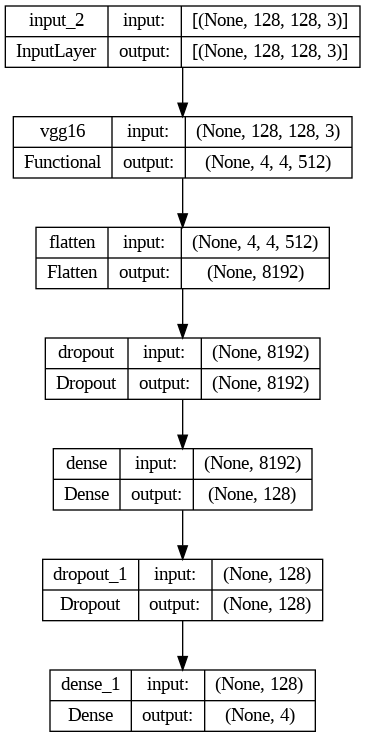

In [16]:
keras.utils.plot_model(model_vgg, show_shapes=True)

In [14]:
model_vgg.compile(optimizer=Adam(learning_rate=0.0005),
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])

In [16]:
# ckp_interval = 5 * int(np.ceil(train_data.shape[0]/batch_size)) # x * epocs
# ckp_folder = r"drive/MyDrive/Tumor_Classification/Model-Checkpoints/vgg"
# ckp_path = os.path.join(ckp_folder,r"epocch_{epoch:02d}.hdf5")

# model_vgg_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=ckp_path,
#     save_weights_only=True,
#     monitor='categorical_accuracy',
#     #mode='max',
#     verbose=1,
#     save_freq= ckp_interval
#     #save_best_only=True
# )

ckp_interval = 5 * int(np.ceil(train_data.shape[0]/batch_size))
ckp_folder = r"F:\work\python\archive\Model-Checkpoints\vgg"  # Local path
os.makedirs(ckp_folder, exist_ok=True)  # Create directory if it doesn't exist
ckp_path = os.path.join(ckp_folder, r"epoch_{epoch:02d}.weights.h5")  # Fixed typo: epocch -> epoch

model_vgg_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckp_path,
    save_weights_only=True,
    monitor='categorical_accuracy',
    verbose=1,
    save_freq=ckp_interval
)

In [20]:
%%time
train_history_vgg = model_vgg.fit(train_dataset,
                          batch_size = batch_size,
                          validation_data = val_dataset,
                          epochs = 30,
                          callbacks = [early_stopping, model_vgg_checkpoint_callback])

# Save the train history
with open(os.path.join(ckp_folder,'train_history_vgg'), 'wb') as file_pi:
    pickle.dump(train_history_vgg, file_pi)


Epoch 1/30
39/39 [==============================] - 724s 18s/step - loss: 1.3357 - categorical_accuracy: 0.3773 - val_loss: 1.1848 - val_categorical_accuracy: 0.5103
Epoch 2/30
39/39 [==============================] - 21s 534ms/step - loss: 1.1606 - categorical_accuracy: 0.4828 - val_loss: 0.9877 - val_categorical_accuracy: 0.6391
Epoch 3/30
39/39 [==============================] - 22s 550ms/step - loss: 0.9954 - categorical_accuracy: 0.5736 - val_loss: 0.6557 - val_categorical_accuracy: 0.7632
Epoch 4/30
39/39 [==============================] - 21s 530ms/step - loss: 0.7187 - categorical_accuracy: 0.7205 - val_loss: 0.6272 - val_categorical_accuracy: 0.7793
Epoch 5/30
38/39 [============================>.] - ETA: 0s - loss: 0.6188 - categorical_accuracy: 0.7722
Epoch 5: saving model to drive/MyDrive/Tumor_Classification/Model-Checkpoints/vgg/epocch_05.hdf5
39/39 [==============================] - 23s 587ms/step - loss: 0.6157 - categorical_accuracy: 0.7736 - val_loss: 0.4490 - val_cat

In [22]:
print(train_history_vgg.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


In [30]:
# If load the history from the previsouly trained model.
with open(os.path.join(ckp_folder,'train_history_vgg'), 'rb') as file_pi:
    train_history_vgg = pickle.load(file_pi)

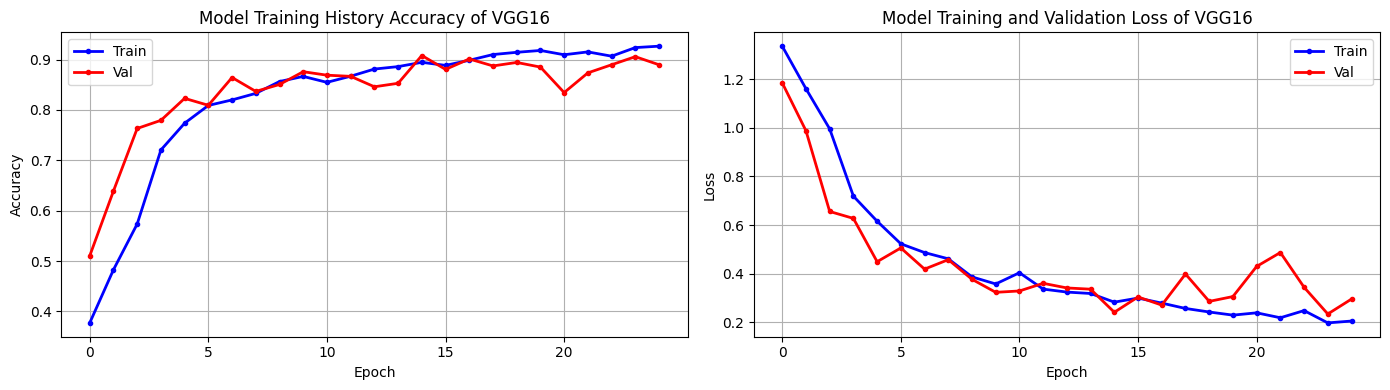

In [31]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))


# Plot Categorical Accuracy and Validation Accuracy
axes[0].grid(True)
axes[0].plot(train_history_vgg.history['categorical_accuracy'], '.b-', linewidth=2, label='Categorical Accuracy')
axes[0].plot(train_history_vgg.history['val_categorical_accuracy'], '.r-', linewidth=2, label='Validation Accuracy')
axes[0].set_title('Model Training History Accuracy of VGG16')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(range(0,len(train_history_vgg.history['categorical_accuracy']),5))
#axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
axes[0].legend(['Train','Val'])


# Plot Training Loss and Validation Loss

#if 'val_loss' in train_history_ResNet50.history:
axes[1].grid(True)
axes[1].plot(train_history_vgg.history['loss'], '.b-', label='Training Loss', linewidth=2)
axes[1].plot(train_history_vgg.history['val_loss'], '.r-', label='Validation Loss', linewidth=2)


axes[1].set_title('Model Training and Validation Loss of VGG16')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_xticks(range(0,len(train_history_vgg.history['loss']),5))


#axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
axes[1].legend(['Train','Val'])


plt.tight_layout()
plt.show()


In [32]:
test_epoch = '15'
weights_path = r"drive/MyDrive/Tumor_Classification/Model-Checkpoints/vgg/epocch_"+test_epoch+".hdf5"
model_vgg.load_weights(weights_path)

In [33]:
# Evaluate the model on the test set for VGG16
evaluation_results_vgg = model_vgg.evaluate(test_dataset)

# Print the evaluation results
print(f'Test Loss: {evaluation_results_vgg[0]}')
print(f'Test Accuracy: {evaluation_results_vgg[1]}')

7/7 [==============================] - 92s 15s/step - loss: 1.6869 - categorical_accuracy: 0.6980
Test Loss: 1.6869125366210938
Test Accuracy: 0.6979695558547974


In [34]:
y_perd_vgg = model_vgg.predict(test_dataset)

7/7 [==============================] - 1s 174ms/step


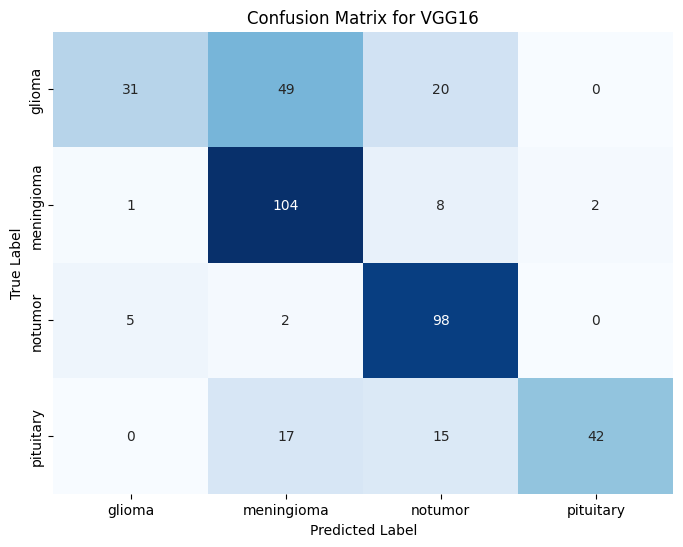

In [35]:
unique_labels = ['glioma','meningioma','notumor','pituitary']

# confusion_matrix for VGG16
conf_matrix = confusion_matrix(test_dataset.labels,np.argmax(y_perd_vgg,axis=-1))
conf_matrix_data = np.array(conf_matrix)


# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_data, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=unique_labels,
            yticklabels=unique_labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for VGG16')
plt.show()

In [37]:
print(classification_report(test_dataset.labels,np.argmax(y_perd_vgg,axis=1)))

              precision    recall  f1-score   support

           0       0.84      0.31      0.45       100
           1       0.60      0.90      0.72       115
           2       0.70      0.93      0.80       105
           3       0.95      0.57      0.71        74

    accuracy                           0.70       394
   macro avg       0.77      0.68      0.67       394
weighted avg       0.75      0.70      0.67       394



In [74]:
model_ResNet50 =  model_def(ResNet50(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet'))
model_ResNet50.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 32768)             0         
                                                                 
 dropout_6 (Dropout)         (None, 32768)             0         
                                                                 
 dense_6 (Dense)             (None, 128)               4194432   
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 516       
                                                       

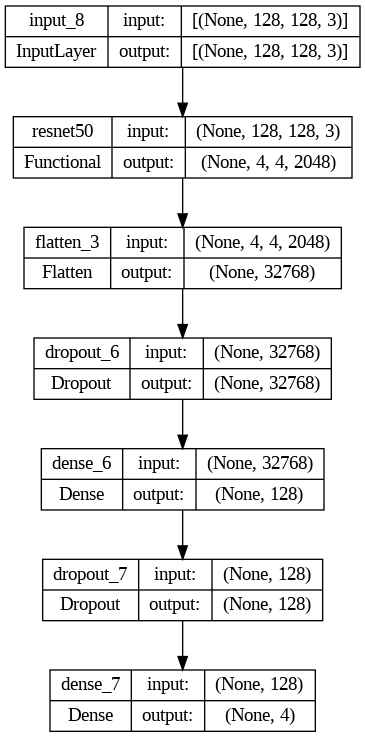

In [75]:
keras.utils.plot_model(model_ResNet50, show_shapes=True)

In [76]:
model_ResNet50.compile(optimizer=Adam(learning_rate=0.00005),
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])

In [ ]:
ckp_interval = 5 * int(np.ceil(train_data.shape[0]/batch_size)) # x * epocs
ckp_path = r"drive/MyDrive/Tumor_Classification/Model-Checkpoints/ResNet50"
ckp_path = os.path.join(ckp_folder,r"epoch_{epoch:02d}.weights.h5")

model_ResNet50_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckp_path,
    save_weights_only=True,
    monitor='categorical_accuracy',
    #mode='max',
    verbose=1,
    save_freq= ckp_interval
    #save_best_only=True
)

In [78]:
%%time
train_history_ResNet50 = model_ResNet50.fit(train_dataset,
                          batch_size = batch_size,
                          validation_data = val_dataset,
                          epochs = 50,
                          callbacks = [model_ResNet50_checkpoint_callback])


# Save the train history
with open(os.path.join(ckp_folder,'train_history_ResNet50'), 'wb') as file_pi:
    pickle.dump(train_history_ResNet50, file_pi)

Epoch 1/50
39/39 [==============================] - 36s 680ms/step - loss: 1.3305 - categorical_accuracy: 0.3801 - val_loss: 1.3803 - val_categorical_accuracy: 0.2920
Epoch 2/50
39/39 [==============================] - 31s 755ms/step - loss: 1.2111 - categorical_accuracy: 0.4540 - val_loss: 1.3460 - val_categorical_accuracy: 0.2920
Epoch 3/50
39/39 [==============================] - 22s 572ms/step - loss: 1.1196 - categorical_accuracy: 0.4807 - val_loss: 1.3424 - val_categorical_accuracy: 0.2943
Epoch 4/50
39/39 [==============================] - 22s 563ms/step - loss: 1.1059 - categorical_accuracy: 0.5010 - val_loss: 1.3252 - val_categorical_accuracy: 0.3379
Epoch 5/50
38/39 [============================>.] - ETA: 0s - loss: 1.1173 - categorical_accuracy: 0.5027
Epoch 5: saving model to drive/MyDrive/Tumor_Classification/Model-Checkpoints/vgg/epocch_05.hdf5
39/39 [==============================] - 22s 565ms/step - loss: 1.1203 - categorical_accuracy: 0.4998 - val_loss: 1.2986 - val_ca

In [80]:
print(train_history_ResNet50.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


In [81]:
# If load the history from the previsouly trained model.
with open(os.path.join(ckp_folder,'train_history_ResNet50'), 'rb') as file_pi:
    train_history_ResNet50 = pickle.load(file_pi)

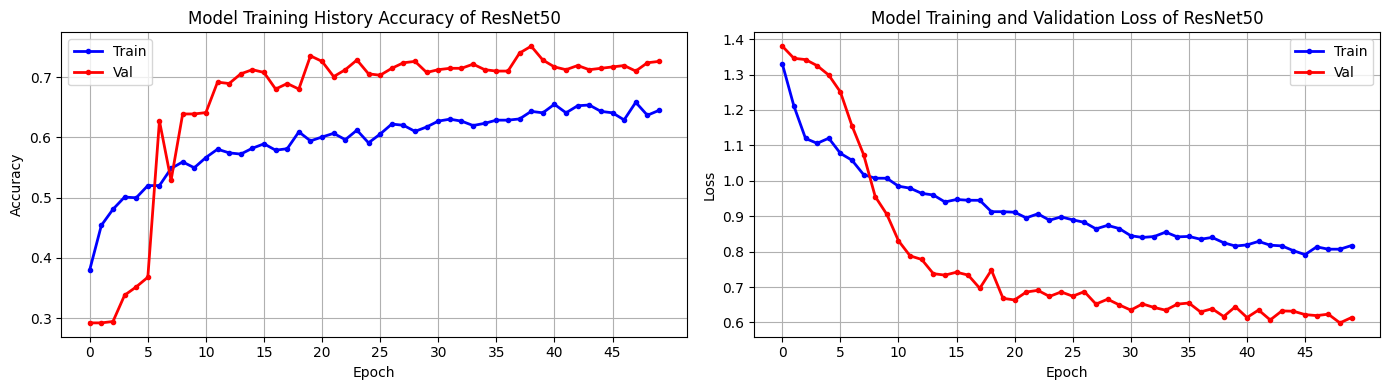

In [82]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

# Plot Categorical Accuracy and Validation Accuracy
axes[0].grid(True)
axes[0].plot(train_history_ResNet50.history['categorical_accuracy'], '.b-', linewidth=2, label='Categorical Accuracy')
axes[0].plot(train_history_ResNet50.history['val_categorical_accuracy'], '.r-', linewidth=2, label='Validation Accuracy')
axes[0].set_title('Model Training History Accuracy of ResNet50')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(range(0,len(train_history_ResNet50.history['categorical_accuracy']),5))
#axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
axes[0].legend(['Train','Val'])

# Plot Training Loss and Validation Loss


#if 'val_loss' in train_history_ResNet50.history:
axes[1].grid(True)
axes[1].plot(train_history_ResNet50.history['loss'], '.b-', label='Training Loss', linewidth=2)
axes[1].plot(train_history_ResNet50.history['val_loss'], '.r-', label='Validation Loss', linewidth=2)

axes[1].set_title('Model Training and Validation Loss of ResNet50')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_xticks(range(0,len(train_history_ResNet50.history['loss']),5))

#axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
axes[1].legend(['Train','Val'])


plt.tight_layout()
plt.show()


In [83]:
test_epoch = '46'
weights_path = r"drive/MyDrive/Tumor_Classification/Model-Checkpoints/ResNet50/epocch_"+test_epoch+".hdf5"
model_ResNet50.load_weights(weights_path)

In [84]:
# Evaluate the model on the test set
evaluation_results_ResNet50 = model_ResNet50.evaluate(test_dataset)

# Print the evaluation results
print(f'Test Loss: {evaluation_results_ResNet50[0]}')
print(f'Test Accuracy: {evaluation_results_ResNet50[1]}')

7/7 [==============================] - 2s 251ms/step - loss: 1.9816 - categorical_accuracy: 0.5228
Test Loss: 1.9816346168518066
Test Accuracy: 0.5228426456451416


In [85]:
y_perd_ResNet50 = model_ResNet50.predict(test_dataset)

7/7 [==============================] - 3s 232ms/step


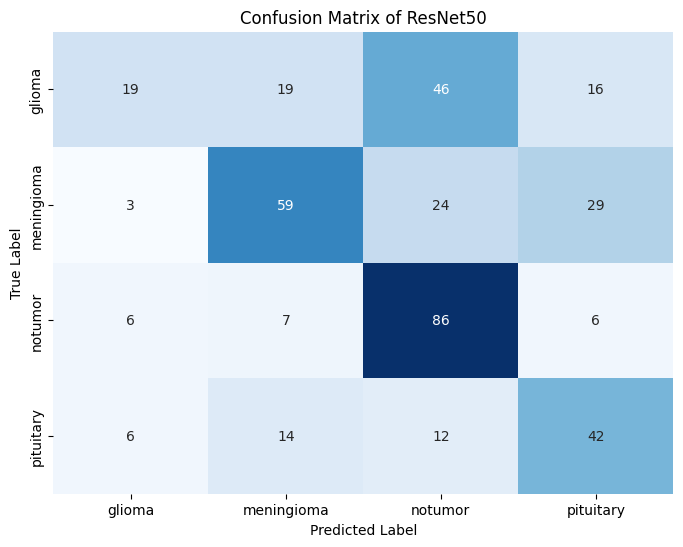

In [86]:
unique_labels = ['glioma','meningioma','notumor','pituitary']

# confusion_matrix of ResNet50
conf_matrix = confusion_matrix(test_dataset.labels,np.argmax(y_perd_ResNet50,axis=-1))
conf_matrix_data = np.array(conf_matrix)


# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_data, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=unique_labels,
            yticklabels=unique_labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of ResNet50')
plt.show()

In [87]:
print(classification_report(test_dataset.labels,np.argmax(y_perd_ResNet50,axis=1)))

              precision    recall  f1-score   support

           0       0.56      0.19      0.28       100
           1       0.60      0.51      0.55       115
           2       0.51      0.82      0.63       105
           3       0.45      0.57      0.50        74

    accuracy                           0.52       394
   macro avg       0.53      0.52      0.49       394
weighted avg       0.54      0.52      0.50       394

